In [29]:
import pandas as pd
import string
import datetime as dt
import numpy as np
import os
import re
import csv
import requests
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns

df1 = pd.read_csv('preprocessed_dataset.csv')

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dropout, Dense, Flatten, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, Bidirectional, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [31]:
#data 32k pertama
df1

,original,translated,cleaned_text,label,casefolded,tokenized,filtered,stemmed,final_sentence
0,My father - all of my life - has shifted betwe...,Ayah saya - sepanjang hidup saya - telah berge...,Ayah saya sepanjang hidup saya telah bergeser ...,0,ayah saya sepanjang hidup saya telah bergeser ...,"['ayah', 'saya', 'sepanjang', 'hidup', 'saya',...","['ayah', 'hidup', 'bergeser', 'monster', 'terb...","['ayah', 'hidup', 'geser', 'monster', 'baik', ...",ayah hidup geser monster baik dukung tenang po...
1,I have health anxiety where I go to the doctor...,Saya memiliki kecemasan kesehatan di mana saya...,Saya memiliki kecemasan kesehatan di mana saya...,3,saya memiliki kecemasan kesehatan di mana saya...,"['saya', 'memiliki', 'kecemasan', 'kesehatan',...","['kecemasan', 'kesehatan', 'pergi', 'dokter', ...","['cemas', 'sehat', 'pergi', 'dokter', 'sakit',...",cemas sehat pergi dokter sakit kepala sederhan...
2,I was thinking about the differences between B...,Saya sedang memikirkan perbedaan antara BPD da...,Saya sedang memikirkan perbedaan antara BPD da...,0,saya sedang memikirkan perbedaan antara bpd da...,"['saya', 'sedang', 'memikirkan', 'perbedaan', ...","['memikirkan', 'perbedaan', 'bpd', 'cptsd', 'a...","['pikir', 'beda', 'bpd', 'cptsd', 'aspek', 'ut...",pikir beda bpd cptsd aspek utama bpd alami tra...
3,Let me preface this by saying that I promise I...,Izinkan saya mengawali ini dengan mengatakan b...,Izinkan saya mengawali ini dengan mengatakan b...,2,izinkan saya mengawali ini dengan mengatakan b...,"['izinkan', 'saya', 'mengawali', 'ini', 'denga...","['izinkan', 'mengawali', 'berjanji', 'berbicar...","['izin', 'awal', 'janji', 'bicara', 'terap', '...",izin awal janji bicara terap percaya rabu deti...
4,"I've been exploring this forum for awhile, and...",Saya telah menjelajahi forum ini untuk sementa...,Saya telah menjelajahi forum ini untuk sementa...,0,saya telah menjelajahi forum ini untuk sementa...,"['saya', 'telah', 'menjelajahi', 'forum', 'ini...","['menjelajahi', 'forum', 'tes', 'bpd', 'konyol...","['jajah', 'forum', 'tes', 'bpd', 'konyol', 'on...",jajah forum tes bpd konyol online dasar asa ma...
...,...,...,...,...,...,...,...,...,...
32525,"Hi everyone,\n\nI’m scared of something that h...","Hai semuanya,\n\nSaya takut pada sesuatu yang ...",Hai semuanya Saya takut pada sesuatu yang terj...,3,hai semuanya saya takut pada sesuatu yang terj...,"['hai', 'semuanya', 'saya', 'takut', 'pada', '...","['hai', 'takut', '17', 'minggu', '2', 'berhubu...","['hai', 'takut', '17', 'minggu', '2', 'hubung'...",hai takut 17 minggu 2 hubung seks gadis hookup...
32526,I keep having a lot of recent health anxiety r...,Saya terus mengalami banyak mimpi terkait kece...,Saya terus mengalami banyak mimpi terkait kece...,3,saya terus mengalami banyak mimpi terkait kece...,"['saya', 'terus', 'mengalami', 'banyak', 'mimp...","['mengalami', 'mimpi', 'terkait', 'kecemasan',...","['alami', 'mimpi', 'kait', 'cemas', 'sehat', '...",alami mimpi kait cemas sehat dengar suara suar...
32527,I'm not diagnosed with BPD but identify with a...,Saya tidak didiagnosis dengan BPD tetapi mengi...,Saya tidak didiagnosis dengan BPD tetapi mengi...,0,saya tidak didiagnosis dengan bpd tetapi mengi...,"['saya', 'tidak', 'didiagnosis', 'dengan', 'bp...","['didiagnosis', 'bpd', 'mengidentifikasi', 'ge...","['diagnosis', 'bpd', 'identifikasi', 'gejala',...",diagnosis bpd identifikasi gejala sesal mempos...
32528,"Whenever I'm panicking about something, and so...","Setiap kali saya panik tentang sesuatu, dan ka...",Setiap kali saya panik tentang sesuatu dan kad...,3,setiap kali saya panik tentang sesuatu dan kad...,"['setiap', 'kali', 'saya', 'panik', 'tentang',...","['kali', 'panik', 'kadang', 'kadang', 'alasan'...","['kali', 'panik', 'kadang', 'kadang', 'alas', ...",kali panik kadang kadang alas tenggorok tutup ...


In [32]:
print(df1.shape)

(32530, 9)


In [33]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32530 entries, 0 to 32529
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   original        32530 non-null  object
 1   translated      32530 non-null  object
 2   cleaned_text    32530 non-null  object
 3   label           32530 non-null  int64 
 4   casefolded      32530 non-null  object
 5   tokenized       32530 non-null  object
 6   filtered        32530 non-null  object
 7   stemmed         32530 non-null  object
 8   final_sentence  32485 non-null  object
dtypes: int64(1), object(8)
memory usage: 2.2+ MB


In [34]:
df1_clean = df1.dropna()

In [35]:
#data 23k kedua
df2 = pd.read_csv('preprocessed_dataset2.csv')

In [36]:
df2

,original,translated,cleaned_text,label,casefolded,tokenized,filtered,stemmed,final_sentence
0,And I think that's the worst part. The BPD alr...,Dan saya pikir itu bagian terburuk. BPD sudah ...,Dan saya pikir itu bagian terburuk BPD sudah m...,0,dan saya pikir itu bagian terburuk bpd sudah m...,"['dan', 'saya', 'pikir', 'itu', 'bagian', 'ter...","['pikir', 'terburuk', 'bpd', 'berjuang', 'peng...","['pikir', 'buruk', 'bpd', 'juang', 'abai', 'al...",pikir buruk bpd juang abai alami episode erti ...
1,How do you deal with it when you’re already de...,Bagaimana Anda menghadapinya saat Anda sudah t...,Bagaimana Anda menghadapinya saat Anda sudah t...,2,bagaimana anda menghadapinya saat anda sudah t...,"['bagaimana', 'anda', 'menghadapinya', 'saat',...","['menghadapinya', 'tertekan']","['hadap', 'tekan']",hadap tekan
2,**im not going to do anything to myself nor am...,** Saya tidak akan melakukan apa pun untuk dir...,Saya tidak akan melakukan apa pun untuk diri s...,0,saya tidak akan melakukan apa pun untuk diri s...,"['saya', 'tidak', 'akan', 'melakukan', 'apa', ...","['berpikir', 'tinggal', 'tunangan', 'satunya',...","['pikir', 'tinggal', 'tunang', 'satu', 'tahun'...",pikir tinggal tunang satu tahun omong kosong p...
3,What causes or tiggers panic attacks when you ...,Apa yang menyebabkan atau menyerang Panik Tigg...,Apa yang menyebabkan atau menyerang Panik Tigg...,3,apa yang menyebabkan atau menyerang panik tigg...,"['apa', 'yang', 'menyebabkan', 'atau', 'menyer...","['menyebabkan', 'menyerang', 'panik', 'tiggers...","['sebab', 'serang', 'panik', 'tiggers', 'bangu...",sebab serang panik tiggers bangun alami lelah ...
4,I turned 21 about a month ago and I took on ab...,Saya berusia 21 tahun sekitar sebulan yang lal...,Saya berusia 21 tahun sekitar sebulan yang lal...,2,saya berusia 21 tahun sekitar sebulan yang lal...,"['saya', 'berusia', '21', 'tahun', 'sekitar', ...","['berusia', '21', 'sebulan', 'mengambil', '5',...","['usia', '21', 'bulan', 'ambil', '5', 'kelas',...",usia 21 bulan ambil 5 kelas organisir bahagia ...
...,...,...,...,...,...,...,...,...,...
23179,While trying to park today I accidentally scra...,"Saat mencoba parkir hari ini, saya secara tida...",Saat mencoba parkir hari ini saya secara tidak...,3,saat mencoba parkir hari ini saya secara tidak...,"['saat', 'mencoba', 'parkir', 'hari', 'ini', '...","['mencoba', 'parkir', 'sengaja', 'menggaruk', ...","['coba', 'parkir', 'sengaja', 'garuk', 'mobil'...",coba parkir sengaja garuk mobil rekan kerja co...
23180,i feel so much guilt and hatred for everything...,Saya merasa sangat bersalah dan kebencian untu...,Saya merasa sangat bersalah dan kebencian untu...,2,saya merasa sangat bersalah dan kebencian untu...,"['saya', 'merasa', 'sangat', 'bersalah', 'dan'...","['bersalah', 'kebencian', 'ayah', 'balapan', '...","['salah', 'benci', 'ayah', 'balap', 'sepeda', ...",salah benci ayah balap sepeda motor trail prof...
23181,Because... how? How do you know what you like ...,Karena ... bagaimana? Bagaimana Anda tahu apa ...,Karena bagaimana Bagaimana Anda tahu apa yang ...,0,karena bagaimana bagaimana anda tahu apa yang ...,"['karena', 'bagaimana', 'bagaimana', 'anda', '...","['suka', 'kenakan', 'makan', 'mendefinisikan',...","['suka', 'kena', 'makan', 'definisi', 'laku', ...",suka kena makan definisi laku minggu pribadi s...
23182,Every time I try it gets worse. When I just si...,Setiap kali saya mencobanya semakin buruk. Ket...,Setiap kali saya mencobanya semakin buruk Keti...,2,setiap kali saya mencobanya semakin buruk keti...,"['setiap', 'kali', 'saya', 'mencobanya', 'sema...","['kali', 'mencobanya', 'buruk', 'duduk', 'dudu...","['kali', 'coba', 'buruk', 'duduk', 'duduk', 's...",kali coba buruk duduk duduk sia sia coba bahag...


In [37]:
print(df2.shape)

(23184, 9)


In [38]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23184 entries, 0 to 23183
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   original        23184 non-null  object
 1   translated      23184 non-null  object
 2   cleaned_text    23184 non-null  object
 3   label           23184 non-null  int64 
 4   casefolded      23184 non-null  object
 5   tokenized       23184 non-null  object
 6   filtered        23184 non-null  object
 7   stemmed         23184 non-null  object
 8   final_sentence  23145 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.6+ MB


In [39]:
df2_clean = df2.dropna()

In [40]:
df_combined = pd.concat([df1_clean, df2_clean], ignore_index=True)

In [41]:
df_combined

,original,translated,cleaned_text,label,casefolded,tokenized,filtered,stemmed,final_sentence
0,My father - all of my life - has shifted betwe...,Ayah saya - sepanjang hidup saya - telah berge...,Ayah saya sepanjang hidup saya telah bergeser ...,0,ayah saya sepanjang hidup saya telah bergeser ...,"['ayah', 'saya', 'sepanjang', 'hidup', 'saya',...","['ayah', 'hidup', 'bergeser', 'monster', 'terb...","['ayah', 'hidup', 'geser', 'monster', 'baik', ...",ayah hidup geser monster baik dukung tenang po...
1,I have health anxiety where I go to the doctor...,Saya memiliki kecemasan kesehatan di mana saya...,Saya memiliki kecemasan kesehatan di mana saya...,3,saya memiliki kecemasan kesehatan di mana saya...,"['saya', 'memiliki', 'kecemasan', 'kesehatan',...","['kecemasan', 'kesehatan', 'pergi', 'dokter', ...","['cemas', 'sehat', 'pergi', 'dokter', 'sakit',...",cemas sehat pergi dokter sakit kepala sederhan...
2,I was thinking about the differences between B...,Saya sedang memikirkan perbedaan antara BPD da...,Saya sedang memikirkan perbedaan antara BPD da...,0,saya sedang memikirkan perbedaan antara bpd da...,"['saya', 'sedang', 'memikirkan', 'perbedaan', ...","['memikirkan', 'perbedaan', 'bpd', 'cptsd', 'a...","['pikir', 'beda', 'bpd', 'cptsd', 'aspek', 'ut...",pikir beda bpd cptsd aspek utama bpd alami tra...
3,Let me preface this by saying that I promise I...,Izinkan saya mengawali ini dengan mengatakan b...,Izinkan saya mengawali ini dengan mengatakan b...,2,izinkan saya mengawali ini dengan mengatakan b...,"['izinkan', 'saya', 'mengawali', 'ini', 'denga...","['izinkan', 'mengawali', 'berjanji', 'berbicar...","['izin', 'awal', 'janji', 'bicara', 'terap', '...",izin awal janji bicara terap percaya rabu deti...
4,"I've been exploring this forum for awhile, and...",Saya telah menjelajahi forum ini untuk sementa...,Saya telah menjelajahi forum ini untuk sementa...,0,saya telah menjelajahi forum ini untuk sementa...,"['saya', 'telah', 'menjelajahi', 'forum', 'ini...","['menjelajahi', 'forum', 'tes', 'bpd', 'konyol...","['jajah', 'forum', 'tes', 'bpd', 'konyol', 'on...",jajah forum tes bpd konyol online dasar asa ma...
...,...,...,...,...,...,...,...,...,...
55625,While trying to park today I accidentally scra...,"Saat mencoba parkir hari ini, saya secara tida...",Saat mencoba parkir hari ini saya secara tidak...,3,saat mencoba parkir hari ini saya secara tidak...,"['saat', 'mencoba', 'parkir', 'hari', 'ini', '...","['mencoba', 'parkir', 'sengaja', 'menggaruk', ...","['coba', 'parkir', 'sengaja', 'garuk', 'mobil'...",coba parkir sengaja garuk mobil rekan kerja co...
55626,i feel so much guilt and hatred for everything...,Saya merasa sangat bersalah dan kebencian untu...,Saya merasa sangat bersalah dan kebencian untu...,2,saya merasa sangat bersalah dan kebencian untu...,"['saya', 'merasa', 'sangat', 'bersalah', 'dan'...","['bersalah', 'kebencian', 'ayah', 'balapan', '...","['salah', 'benci', 'ayah', 'balap', 'sepeda', ...",salah benci ayah balap sepeda motor trail prof...
55627,Because... how? How do you know what you like ...,Karena ... bagaimana? Bagaimana Anda tahu apa ...,Karena bagaimana Bagaimana Anda tahu apa yang ...,0,karena bagaimana bagaimana anda tahu apa yang ...,"['karena', 'bagaimana', 'bagaimana', 'anda', '...","['suka', 'kenakan', 'makan', 'mendefinisikan',...","['suka', 'kena', 'makan', 'definisi', 'laku', ...",suka kena makan definisi laku minggu pribadi s...
55628,Every time I try it gets worse. When I just si...,Setiap kali saya mencobanya semakin buruk. Ket...,Setiap kali saya mencobanya semakin buruk Keti...,2,setiap kali saya mencobanya semakin buruk keti...,"['setiap', 'kali', 'saya', 'mencobanya', 'sema...","['kali', 'mencobanya', 'buruk', 'duduk', 'dudu...","['kali', 'coba', 'buruk', 'duduk', 'duduk', 's...",kali coba buruk duduk duduk sia sia coba bahag...


In [42]:
print(df_combined.shape)

(55630, 9)


In [43]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55630 entries, 0 to 55629
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   original        55630 non-null  object
 1   translated      55630 non-null  object
 2   cleaned_text    55630 non-null  object
 3   label           55630 non-null  int64 
 4   casefolded      55630 non-null  object
 5   tokenized       55630 non-null  object
 6   filtered        55630 non-null  object
 7   stemmed         55630 non-null  object
 8   final_sentence  55630 non-null  object
dtypes: int64(1), object(8)
memory usage: 3.8+ MB


In [44]:
df_cleaned = df_combined.dropna()

In [45]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55630 entries, 0 to 55629
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   original        55630 non-null  object
 1   translated      55630 non-null  object
 2   cleaned_text    55630 non-null  object
 3   label           55630 non-null  int64 
 4   casefolded      55630 non-null  object
 5   tokenized       55630 non-null  object
 6   filtered        55630 non-null  object
 7   stemmed         55630 non-null  object
 8   final_sentence  55630 non-null  object
dtypes: int64(1), object(8)
memory usage: 3.8+ MB


In [46]:
df_cleaned['label'].value_counts()

label
0    20269
3    15674
2    11526
5     3686
1     3384
4     1091
Name: count, dtype: int64

In [ ]:
# Menentukan jumlah minimal dari semua kelas
min_count = df_cleaned['label'].value_counts().min()

# Undersample semua kelas ke jumlah minimal tersebut
df_underbalanced = (
    df_cleaned.groupby('label')
    .apply(lambda x: x.sample(n=min_count, random_state=42))
    .reset_index(drop=True)
)

In [ ]:
df_underbalanced['label'].value_counts()

In [47]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55630 entries, 0 to 55629
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   original        55630 non-null  object
 1   translated      55630 non-null  object
 2   cleaned_text    55630 non-null  object
 3   label           55630 non-null  int64 
 4   casefolded      55630 non-null  object
 5   tokenized       55630 non-null  object
 6   filtered        55630 non-null  object
 7   stemmed         55630 non-null  object
 8   final_sentence  55630 non-null  object
dtypes: int64(1), object(8)
memory usage: 3.8+ MB


In [48]:
y = df_cleaned['label']
X = df_cleaned['final_sentence']

In [ ]:
y = df_underbalanced['label']
X = df_underbalanced['final_sentence']

In [ ]:
# Maksimal jumlah data per kelas
max_per_class = 5000

# Ambil sample dari tiap kelas (maksimum 5000)
df_sampled5k = (
    df_cleaned.groupby('label', group_keys=False)
    .apply(lambda x: x.sample(n=min(len(x), max_per_class), random_state=42))
)

# Cek hasil distribusi
print(df_sampled5k['label'].value_counts())

In [ ]:
y = df_sampled5k['label']
X = df_sampled5k['final_sentence']

In [49]:
#copy data awal untuk di gunakan di tokenizer
y_cate = y.copy()
X_tok = X.copy()

In [50]:
# Encode label menjadi one-hot
num_classes = 6
labels_encoded = to_categorical(y_cate, num_classes=num_classes)

# Tokenisasi teks
tokenizer = Tokenizer(num_words=1000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_tok)
sequences = tokenizer.texts_to_sequences(X_tok)

# Padding sequence supaya panjangnya sama
max_len = 500
teKs = pad_sequences(sequences, maxlen=max_len, padding='post')

# Split data train-test
X_train, X_test, y_train, y_test = train_test_split(teKs, labels_encoded, test_size=0.2, random_state=42)

In [51]:
class StopAtAccuracy(Callback):
    def __init__(self, target_acc=0.94):
        super().__init__()
        self.target_acc = target_acc

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        if val_acc is not None and val_acc >= self.target_acc:
            print(f"\n✅ Target akurasi {self.target_acc*100:.0f}% tercapai di epoch {epoch+1}. Training dihentikan.")
            self.model.stop_training = True

In [53]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(input_dim=1000, output_dim=256, input_length=max_len))
model_LSTM.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01), return_sequences=True))
model_LSTM.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)))
model_LSTM.add(Dense(128, activation='relu'))
model_LSTM.add(Dense(64, activation='relu'))
model_LSTM.add(Dense(32, activation='relu'))
model_LSTM.add(Dense(6, activation='softmax'))
model_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

#point stopping kustom pada 94%
callbacks = StopAtAccuracy(target_acc=0.94)

# Melatih model dengan early stopping kustom
history = model_LSTM.fit(X_train, y_train, epochs=20, batch_size=128, verbose=2, callbacks=[callbacks], validation_data=(X_test, y_test))

Epoch 1/20
348/348 - 1269s - 4s/step - accuracy: 0.3588 - loss: 1.9220 - val_accuracy: 0.3611 - val_loss: 1.4869
Epoch 2/20
348/348 - 1237s - 4s/step - accuracy: 0.3652 - loss: 1.4779 - val_accuracy: 0.3611 - val_loss: 1.4884
Epoch 3/20
348/348 - 1282s - 4s/step - accuracy: 0.3652 - loss: 1.4781 - val_accuracy: 0.3611 - val_loss: 1.4866
Epoch 4/20
348/348 - 1217s - 3s/step - accuracy: 0.3652 - loss: 1.4775 - val_accuracy: 0.3611 - val_loss: 1.4883
Epoch 5/20
348/348 - 1205s - 3s/step - accuracy: 0.3652 - loss: 1.4778 - val_accuracy: 0.3611 - val_loss: 1.4874
Epoch 6/20
348/348 - 1183s - 3s/step - accuracy: 0.3652 - loss: 1.4780 - val_accuracy: 0.3611 - val_loss: 1.4877
Epoch 7/20
348/348 - 1211s - 3s/step - accuracy: 0.3652 - loss: 1.4776 - val_accuracy: 0.3611 - val_loss: 1.4895
Epoch 8/20
348/348 - 1194s - 3s/step - accuracy: 0.3652 - loss: 1.4777 - val_accuracy: 0.3611 - val_loss: 1.4862
Epoch 9/20
348/348 - 1202s - 3s/step - accuracy: 0.3652 - loss: 1.4776 - val_accuracy: 0.3611 - 

In [56]:
model_LSTM.save('model_lstm.h5')


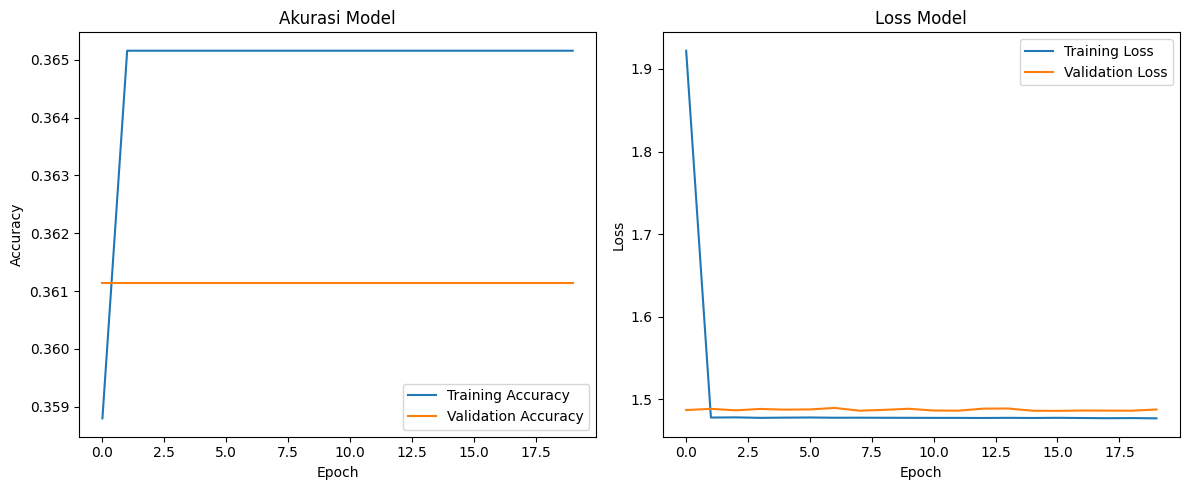

In [57]:
# Plot akurasi training dan validasi
plt.figure(figsize=(12, 5))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [54]:
from sklearn.metrics import confusion_matrix, classification_report

348/348 ━━━━━━━━━━━━━━━━━━━━ 30s 86ms/step


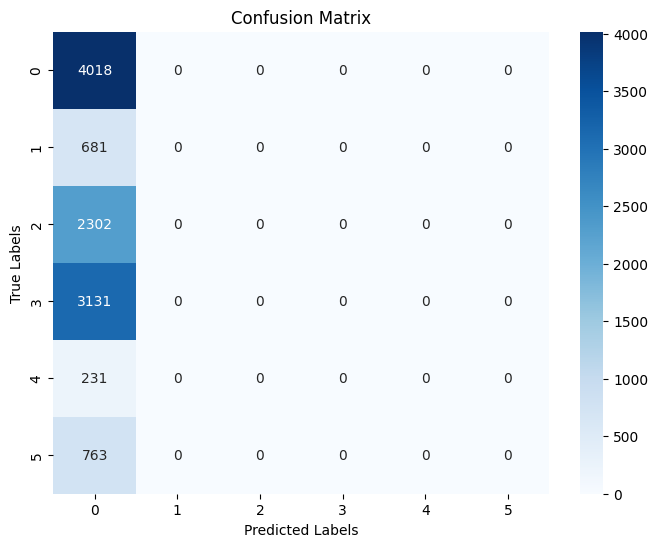

              precision    recall  f1-score   support

           0       0.36      1.00      0.53      4018
           1       0.00      0.00      0.00       681
           2       0.00      0.00      0.00      2302
           3       0.00      0.00      0.00      3131
           4       0.00      0.00      0.00       231
           5       0.00      0.00      0.00       763

    accuracy                           0.36     11126
   macro avg       0.06      0.17      0.09     11126
weighted avg       0.13      0.36      0.19     11126



c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [58]:
# Prediksi model pada data test
y_pred_prob = model_LSTM.predict(X_test)

# Ambil index label tertinggi (kelas prediksi dan aktual)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Tampilkan sebagai heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Tambahan: tampilkan precision, recall, f1-score
print(classification_report(y_true, y_pred))